# Introduction and objectives

In this notebook I attempt to find the best strategy to play blackjack using **Reinforcement Learning** (RL) techniques. More specifically, I will use ***on-policy Monte Carlo Learning***. This technique tries to estimate $q_{*}(S_t,A_t) = E_{\pi_{*}}[Gt |S_t=s, A_t=a]$. In words, this method aims to estimate the expected value of a certain state-action pair, $(S_t,A_t)$, given an agent (in this case the player) follows the optimal strategy $\pi_{*}$. In the end, this method will yield a policy $\pi(s)$ which tells the agent which action to take given a certain state $s$. 

## The game of Blackjack

Blackjack is one of the most popular card games. The game can sometimes have different rules that depend on each casino. In this case, I will use the following rules to play blackjack: at the start of each hand, the player gets dealt two cards, and the dealer gets dealt two cards as well. The player can only see **one** of the dealer's cards. Each card's value is its face number, unless the card is a Jack, Queen or King, in which case the card's value is 10; in the case the card is an Ace, the card's value can be 11 or 1. The objective of the game is to get to 21, or as close to it without going over it (bust), in which case you lose. 
Once the player has his hand and can see one dealer's cards, he can decide from three actions: ask for another card (hit), keep his hand as is (stand), or double his bet, but only get dealt one more card and no more (double down). 
The player wins if he is closer to 21 than the dealer and hasn't go bust, or if the dealer go bust. 
One more thing, the payout for hitting a blackjack is 3/2, instead of 1.  

In [81]:
# @author: Alvaro Romo
# Libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [82]:
# Actions and policy encoding
action_hit = 0 # ask dealer for another card
action_stand = 1 # stay with given cards
action_dd = 2 # double down given the card dealing
actions = np.array([action_hit, action_stand, action_dd])

# delaers behavior: dealer always asks for a card when he has 16 or less; he stands otherwise
def dealer_action(card_sum):
    if card_sum <= 16:
        return action_hit
    else:
        return action_stand
    
# we assume cards are drawn from an infinite deck of cards

def get_card():
    card = np.random.randint(1,14) # 1 = Ace
    card = min(10, card) # 11, 12, and 13 are worth 10
    return card

def get_card_value(card):
    # card: an int between 1 and 13, where an ace's value is 11, and J, Q, and K's value is 10
    if card == 1: # case of an ace
        return 11
    else: # Any other card from 2 to 9
        return card
    
    
def play_hand(policy):
    # policy: it's a function of the states = (soft_ace, player_sum, dealer_show) which outputs an action
    
    player_sum = 0
    soft_ace_player = False
    player_trajectory = [] # sequence of S0, A0, R1, S1, A1, R2,..., A(T-1), R(T)
    
    dealer_card1 = 0 # this is the card the player can see
    dealer_card2 = 0
    soft_ace_dealer = False
    
    # Deal a hand for the player: two cards
    player_card1 = get_card()
    player_card2 = get_card()
    
    # Get player sum
    player_sum = get_card_value(player_card1) + get_card_value(player_card2)
    
    # The only way a player gets 22 is if the player has two aces
    soft_ace_count = 0
    
    if player_sum > 21: # then a player has two aces
        player_sum = player_sum - 10 # uses one ace as one
        soft_ace_count = 1
    
    else: # player sum is less than 21 but may have an ace
        soft_ace_count = int((player_card1 == 1)) + int((player_card2 == 1)) # if neither is ace, sum is 0
        
    # if soft_ace_count > 0, the player has an ace he CAN use as a one, that is using as an 11
    soft_ace_player = (soft_ace_count > 0)
    
    
    # Deal a hand for the dealer: first card is the one the player sees; the second one is hidden for the player
    dealer_card1 = get_card()
    dealer_card2 = get_card()
    
    state = [soft_ace_player, player_sum, dealer_card1]
    
    dealer_sum = get_card_value(dealer_card1) + get_card_value(dealer_card2)
    soft_ace_dealer = (dealer_card1 == 1) or (dealer_card2 == 1)
    soft_ace_dealer_count = int(soft_ace_dealer) # one or two
    
    # if the dealer's sum is > 21, he must hold two aces. 
    if dealer_sum > 21:
        # use one ace as 1 rather than 11
        dealer_sum = dealer_sum - 10
        soft_ace_dealer_count = 1 # he holds now one ace he could use as a one
        
    soft_ace_dealer = (soft_ace_dealer_count > 0)
    
    # With both hands, we play a game:
    
    # Player's turn to decide what to do
    while True:
        action = policy(soft_ace_player, player_sum, dealer_card1)
        player_trajectory.append([(soft_ace_player, player_sum, dealer_card1), action])
        
        if action == action_stand:
            break # game stops and the player has to see what the dealer has (exits while loop)
            
        # When the player double downs, he asks for just ONE additional card
        if action == action_dd: 
            new_card = get_card()
            player_sum += get_card_value(new_card)
            
            # If the player busts, he loses double what he bet
            if player_sum > 21 and (new_card == 1): # player has drawn another ace 
                player_sum -= 10
                
            # Player busts with double down
            if player_sum > 21:
                return state, -2, player_trajectory
            
            break # if a player double downs, he can't ask for another card
            
        # The only remaining case: the player asks for another card
        if action == action_hit: 
            new_card = get_card()
            
            soft_ace_count = soft_ace_count + int((new_card == 1)) # only increases if the player got dealt an ace
            player_sum += get_card_value(new_card)
            
            while player_sum > 21 and soft_ace_count > 0:
                player_sum = player_sum - 10 # player uses an ace as 1
                soft_ace_count -= 1
                
            # Player busts
            if player_sum > 21: # in this case, the player no longer has aces to use
                return state, -1, player_trajectory
            
            
    # Dealer's turn to decide what to do
    while True:
        action_d = dealer_action(dealer_sum)
        if action_d == action_stand:
            break # time to compare sums
            
        # Otherwise, the dealer hits
        new_card = get_card()
        soft_ace_dealer_count += int((new_card == 1))
        
        dealer_sum += get_card_value(new_card)
        
        while dealer_sum > 21 and soft_ace_dealer_count > 0:
            dealer_sum = dealer_sum - 10 # dealer uses a sum as a one
            soft_ace_dealer_count -= 1
            
            
        # Dealer busts   
        if dealer_sum > 21: 
            if action == action_dd:
                if player_sum == 21: # blackjack pays 3/2
                    return state, 2*(3/2), player_trajectory
                else:
                    return state, 2, player_trajectory
                
            else: # player didn't double down
                if player_sum == 21:
                    return state, 3/2, player_trajectory
                else:
                    return state, 1, player_trajectory
                
                
    # Once the dealer has chosen to stand, we compare sums:
    
    if player_sum > dealer_sum: # player wins
        if action == action_dd:
            return state, 2, player_trajectory
        else:
            return state, 1, player_trajectory
        
    elif player_sum == dealer_sum: 
        return state, 0, player_trajectory
    
    else: # player loses
        if action == action_dd:
            return state, -2, player_trajectory
        else:
            return state, -1, player_trajectory
                  
        

In [83]:
# Monte Carlo on policy method

def mc_control_epsilon(episodes, epsilon):
    # Initializations
    
    player_sum_states = np.arange(1,22)
    dealer_card_states = np.arange(1,11)
    shape = (len(player_sum_states), len(dealer_card_states), 2, len (actions))
    action_values = np.zeros(shape = shape)
    state_action_counts = np.ones(shape = shape)
    Q_matrix = action_values / state_action_counts
        
    # Go through trajectories
    for episode in tqdm(range(episodes)):
        # Epsilon greedy policy 
        def epsilon_greedy_policy(soft_ace_flag, player_sum, dealer_card):
            # An epsilon greedy policy chooses the action with the highest Q value, but it sometimes
            # chooses a random policy for exploration. 
            Q_matrix = action_values / state_action_counts
            state_values = Q_matrix[player_sum-1,dealer_card-1,int(soft_ace_flag),:]
            aux = np.random.binomial(n=1, p = 1-epsilon)
            if aux == 1:
                return np.random.choice(np.flatnonzero(state_values == state_values.max()))
            else:
                return np.random.choice(np.arange(len(state_values)))
        
        state, reward, trajectory = play_hand(epsilon_greedy_policy) # using eps-greedy
        
        for (soft_ace_flag, player_sum, dealer_card), action in trajectory:
            action_values[player_sum-1, dealer_card-1, int(soft_ace_flag),action] += reward
            state_action_counts[player_sum-1, dealer_card-1, int(soft_ace_flag), action] += 1
            
        
            
    Q_matrix = action_values / state_action_counts       
        
    return Q_matrix 

In [6]:
Q_ = mc_control_epsilon(episodes=5000000, epsilon=0.3)

100%|██████████| 5000000/5000000 [05:08<00:00, 16206.21it/s]


In [8]:
def mc_optimal_policy(soft_ace_flag, player_sum, dealer_card):
    return np.argmax(Q_[player_sum-1, dealer_card-1, int(soft_ace_flag), :])

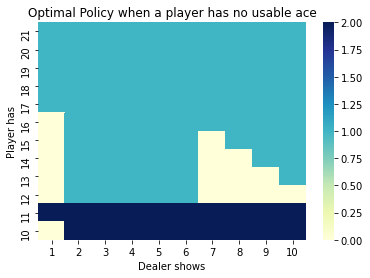

In [77]:
# Filter Q values by having a soft ace or not
no_ace_Q = Q_[:,:,0,:]
with_ace_Q = Q_[:,:,1,:]

# Policies
no_ace_pi = np.argmax(no_ace_Q, axis = -1)
with_ace_pi = np.argmax(with_ace_Q, axis = -1)

# Filter to display only from when a player has a 10
no_ace_pi2 = no_ace_pi[9:, :]
with_ace_pi2 = with_ace_pi[9:, :]

sns.heatmap(np.flipud(no_ace_pi2), cmap = 'YlGnBu', xticklabels = range(1,11),
           yticklabels = list(reversed(range(10,22))))
plt.xlabel('Dealer shows')
plt.ylabel('Player has')
plt.title('Optimal Policy when a player has no usable ace')
plt.show()

# Dark blue means a player should double down
# Yellow means a player should hit
# Light blue means a player should stand


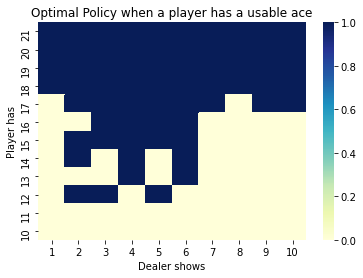

In [80]:
sns.heatmap(np.flipud(with_ace_pi2), cmap = 'YlGnBu', xticklabels = range(1,11),
           yticklabels = list(reversed(range(10,22))))
plt.xlabel('Dealer shows')
plt.ylabel('Player has')
plt.title('Optimal Policy when a player has a usable ace')
plt.show()
# Dark blue means a player should stand
# Yellow means a player should hit

In [72]:
hands = 10000
rewards = []

for i in tqdm(range(hands)):
    _, reward, trajectory = play_hand(mc_optimal_policy)
    rewards.append(reward)

100%|██████████| 10000/10000 [00:00<00:00, 37957.40it/s]


In [86]:
wins = 0
wins_value = 0
losses = 0
losses_value = 0
draws = 0
for r in rewards:
    if r>0:
        wins +=1
        wins_value += r
        
    elif r == 0:
        draws +=1
    else:
        losses += 1
        losses_value += r
        
print('The results for the optimal policy:')

print('The player wins {}% of the time'.format(wins/len(rewards)))
print('The player loses {}% of the time'.format(losses/len(rewards)))
print('The player draws {}% of the time'.format(draws/len(rewards)))

print('Total positive rewards: {}'.format(wins_value))
print('Total losses: {}'.format(losses_value))

The results for the optimal policy:
The player wins 0.4265% of the time
The player loses 0.4983% of the time
The player draws 0.0752% of the time
Total positive rewards: 5040.0
Total losses: -5479


In [65]:
# We can compare this performace with another simple common strategy for a player:
def basic_policy(soft_ace_flag, player_sum, dealer_card):
    if player_sum == 20 or player_sum == 21:
        return action_stand
    elif player_sum == 10 or player_sum == 1:
        return action_dd
    else:
        return action_hit

In [66]:
hands = 10000
rewards_b = []

for i in tqdm(range(hands)):
    _, reward_b, trajectory = play_hand(basic_policy)
    rewards_b.append(reward_b)

100%|██████████| 10000/10000 [00:00<00:00, 48949.24it/s]


In [88]:
wins = 0
wins_value = 0
losses = 0
losses_value = 0
draws = 0
for r in rewards_b:
    if r>0:
        wins +=1
        wins_value += r
        
    elif r == 0:
        draws +=1
    else:
        losses += 1
        losses_value += r
        
print('The results for the basic policy:')        

print('The player wins {}% of the time'.format(wins/len(rewards_b)))
print('The player loses {}% of the time'.format(losses/len(rewards_b)))
print('The player draws {}% of the time'.format(draws/len(rewards_b)))

print('Total positive rewards: {}'.format(wins_value))
print('Total losses: {}'.format(losses_value))

The results for the basic policy:
The player wins 0.298% of the time
The player loses 0.6409% of the time
The player draws 0.0611% of the time
Total positive rewards: 3439.5
Total losses: -6583


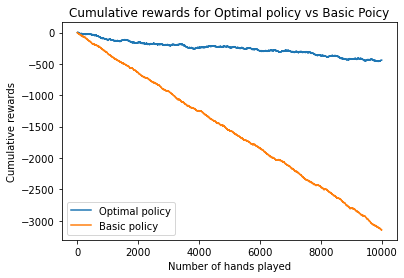

In [89]:
# Cumulative rewards over time
op_acc = np.add.accumulate(rewards)
basic_acc = np.add.accumulate(rewards_b)

plt.plot(np.arange(hands), op_acc, label = 'Optimal policy')
plt.plot(np.arange(hands), basic_acc, label = 'Basic policy')
plt.legend()
plt.title('Cumulative rewards for Optimal policy vs Basic Poicy')
plt.xlabel('Number of hands played')
plt.ylabel('Cumulative rewards')
plt.show()

### Final note

As we can see above, the optimal policy also losses money over time, but it does so in a slower way than our benchmark policy. Of course there is no policy that produces positive returns over time, as the game of blackjack is desgined to have a house edge, but this example shows how Reinforcement Learning can be used to produce policies that make the agent act optimally with a given state and how it can improve performance (in this case, reduce losses). 